In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from simglucose.envs import T1DSimEnv
import gym
from gym.envs.registration import register

### Data Exploration

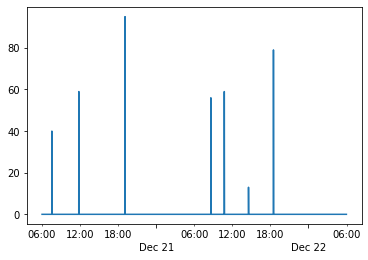

In [4]:
from simglucose.simulation.scenario import Action, Scenario
import numpy as np
from scipy.stats import truncnorm
from datetime import datetime
import logging

logger = logging.getLogger(__name__)


class RandomScenario(Scenario):
    def __init__(self, start_time, seed=None):
        Scenario.__init__(self, start_time=start_time)
        self.seed = seed

    def get_action(self, t):
        # t must be datetime.datetime object
        delta_t = t - datetime.combine(t.date(), datetime.min.time())
        t_sec = delta_t.total_seconds()

        if t_sec < 1:
            logger.info('Creating new one day scenario ...')
            self.scenario = self.create_scenario()

        t_min = np.floor(t_sec / 60.0)

        if t_min in self.scenario['meal']['time']:
            logger.info('Time for meal!')
            idx = self.scenario['meal']['time'].index(t_min)
            return Action(meal=self.scenario['meal']['amount'][idx])
        else:
            return Action(meal=0)

    def create_scenario(self):
        scenario = {'meal': {'time': [], 'amount': []}}

        # Probability of taking each meal
        # [breakfast, snack1, lunch, snack2, dinner, snack3]
        prob = [0.95, 0.3, 0.95, 0.3, 0.95, 0.3]
        time_lb = np.array([5, 9, 10, 14, 16, 20]) * 60
        time_ub = np.array([9, 10, 14, 16, 20, 23]) * 60
        time_mu = np.array([7, 9.5, 12, 15, 18, 21.5]) * 60
        time_sigma = np.array([60, 30, 60, 30, 60, 30])
        amount_mu = [45, 10, 70, 10, 80, 10]
        amount_sigma = [10, 5, 10, 5, 10, 5]

        for p, tlb, tub, tbar, tsd, mbar, msd in zip(prob, time_lb, time_ub,
                                                     time_mu, time_sigma,
                                                     amount_mu, amount_sigma):
            if self.random_gen.rand() < p:
                tmeal = np.round(
                    truncnorm.rvs(a=(tlb - tbar) / tsd,
                                  b=(tub - tbar) / tsd,
                                  loc=tbar,
                                  scale=tsd,
                                  random_state=self.random_gen))
                scenario['meal']['time'].append(tmeal)
                scenario['meal']['amount'].append(
                    max(round(self.random_gen.normal(mbar, msd)), 0))

        return scenario

    def reset(self):
        self.random_gen = np.random.RandomState(self.seed)
        self.scenario = self.create_scenario()

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        self._seed = seed
        self.reset()


from datetime import time
from datetime import timedelta
import copy
now = datetime.now()
t0 = datetime.combine(now.date(), time(6, 0, 0, 0))
t = copy.deepcopy(t0)
sim_time = timedelta(days=2)

scenario = RandomScenario(seed=1, start_time=t0)
m = []
T = []
while t < t0 + sim_time:
    action = scenario.get_action(t)
    m.append(action.meal)
    T.append(t)
    t += timedelta(minutes=1)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.plot(T, m)
ax = plt.gca()
ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M\n'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%b %d'))
plt.show()

Episode finished after 118 timesteps


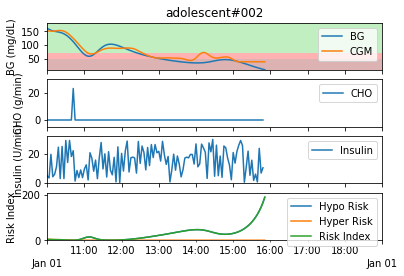

In [9]:
def custom_reward(BG_last_hour):
    if BG_last_hour[-1] > 180:
        return -1
    elif BG_last_hour[-1] < 70:
        return -2
    else:
        return 1


# register(
#     id='simglucose-adolescent2-v0',
#     entry_point='simglucose.envs:T1DSimEnv',
#     kwargs={'patient_name': 'adolescent#002',
#             'reward_fun': custom_reward}
# )

env = gym.make('simglucose-adolescent2-v0')

reward = 1
done = False

observation = env.reset()
for t in range(200):
    env.render(mode='human')
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # print(observation)
    # print("Reward = {}".format(reward))
    if done:
        print("Episode finished after {} timesteps".format(t + 1))
        break

In [3]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import datetime

# specify start_time as the beginning of today
now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())

In [5]:

# --------- Create Custom Scenario --------------
# Create a simulation environment
patient = T1DPatient.withName('adolescent#001')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
# custom scenario is a list of tuples (time, meal_size)
scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)
env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s2 = SimObj(env, controller, timedelta(days=1), animate=False, path='./results/')
results2 = sim(s2)


Process ID: 1736
Simulation starts ...
Simulation Completed!


In [6]:
results2

,BG,CGM,CHO,insulin,LBGI,HBGI,Risk
Time,,,,,,,
2023-12-20 00:00:00,149.020000,165.793949,0.0,0.013933,0.000000,2.755276,2.755276
2023-12-20 00:03:00,149.020000,161.582022,0.0,0.013933,0.000000,2.755276,2.755276
2023-12-20 00:06:00,149.020000,159.239373,0.0,0.013933,0.000000,2.755276,2.755276
2023-12-20 00:09:00,149.020000,157.472710,0.0,0.013933,0.000000,2.755276,2.755276
2023-12-20 00:12:00,149.020000,156.108950,0.0,0.013933,0.000000,2.755276,2.755276
...,...,...,...,...,...,...,...
2023-12-20 23:48:00,93.366001,93.736518,0.0,0.013933,1.204979,0.000000,1.204979
2023-12-20 23:51:00,93.288345,92.966818,0.0,0.013933,1.215732,0.000000,1.215732
2023-12-20 23:54:00,93.210068,92.409334,0.0,0.013933,1.226629,0.000000,1.226629


### Solution

- I don't know how to use the variables that the model says or if we even have that information available.
- For the moment the loop is only over one patient, not properly training yet
- Implement reward function

In [2]:
# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        # Define your neural network architecture
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

##### select_action funtion

1. The chosen action $a_t$ represents a percentage modulation $alpha_t$ of the mealtime insulin dose suggested by the standard therapy.
2. The modulation factor $alpha_t$) is randomly chosen from a set of possible percentage modulations.
3. The insulin amount suggested by the DDQN algorithm at time step $t$ is calculated using the formula: $BC_{ddqn}(t) = BC_s(t) + \alpha_t \cdot BC_s(t)$.

In [3]:
# Define the DDQ Agent
class DQNAgent:
    def __init__(self, input_size, output_size, gamma=0.99, learning_rate=0.001):
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Q-networks
        self.q_network = QNetwork(input_size, output_size).to(self.device)
        self.target_q_network = QNetwork(input_size, output_size).to(self.device)
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.q_network(state_tensor)
        action_index = q_values.argmax(1).item()
        # Possible percentage modulations of the insulin dose
        modulation_percentages = [25, 20, 10, 0, -10, -20, -25]
        # now selecting the alpha percentage as a random choice from the modulation percentages
        alpha_percentage = np.random.choice(modulation_percentages)
        alpha_factor = 1 + (alpha_percentage / 100.0)  # Convert percentage to a factor

        # Apply the modulation to the insulin dose suggested by standard therapy (BCs)
        action_value = alpha_factor * action_index

        return action_value

    def update_q_network(self, state, action, reward, next_state, done):
        state_tensor = torch.FloatTensor(state).to(self.device)
        next_state_tensor = torch.FloatTensor(next_state).to(self.device)
        action_tensor = torch.FloatTensor([action]).to(self.device)
        reward_tensor = torch.FloatTensor([reward]).to(self.device)

        # Q-value prediction for all actions
        q_values = self.q_network(state_tensor)
        
        # Action_tensor and q_values shapes must match
        action_tensor = action_tensor.expand_as(q_values)

        # Q-value for the selected action
        selected_q_value = torch.sum(q_values * action_tensor, dim=0, keepdim=True)

        with torch.no_grad():
            # Double Q-learning: Use the target network for action selection
            next_q_values = self.target_q_network(next_state_tensor)
            next_action_index = next_q_values.argmax(0, keepdim=True)
            target_q_values = reward_tensor + self.gamma * next_q_values.gather(0, next_action_index) * (1 - done)

        # Q-network loss
        loss = nn.functional.mse_loss(selected_q_value, target_q_values)

        # Backpropagation and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_q_network(self):
        # Update the target Q-network by copying the parameters from the current Q-network
        self.target_q_network.load_state_dict(self.q_network.state_dict())

In [4]:
# Simglucose environment setup
patient_name = "adolescent#010"
env = T1DSimEnv(patient_name=patient_name)

# DDQ Agent setup
state_size = len(env.observation_space.low)  # Size of the state vector
action_size = len(env.action_space.low)  # Size of the action space
agent = DQNAgent(input_size=state_size, output_size=action_size)

In [5]:
state = env.reset()
action = agent.select_action(state)
env.step(action)

Step(observation=Observation(CGM=149.80502445158902), reward=0.21085887551353366, done=False, info={'sample_time': 3.0, 'patient_name': 'adolescent#010', 'meal': 0.0, 'patient_state': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.69891197e+02,
        1.65975038e+02,  6.30215227e+00, -1.33136366e-02,  1.08236338e+02,
        1.08239971e+02,  3.58486790e+00,  8.84671285e+01,  7.75725653e+01,
        2.72581852e+02]), 'time': datetime.datetime(2018, 1, 1, 15, 3), 'bg': 147.92056439066695, 'lbgi': 0.0, 'hbgi': 2.611626127620977, 'risk': 2.611626127620977})

In [11]:
# Training loop
num_episodes = 1000
TARGET_UPDATE_FREQUENCY = 10
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    first_iteration = True

    while True:
        action = agent.select_action(state)

        # Step through the environment
        next_state, reward, done, _ = env.step(action)

        # Update Q-network
        agent.update_q_network(state, action, reward, next_state, done)

        # Update target Q-network periodically
        if episode % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_q_network()

        state = next_state
        total_reward += reward

        if done:
            break

    print(f"Episode: {episode + 1}, Total Reward: {total_reward}, GCM: {next_state.CGM}")

Episode: 1, Total Reward: -97.87264021170513, GCM: 593.3493234822606
Episode: 2, Total Reward: -97.30607057598033, GCM: 600.0
Episode: 3, Total Reward: -96.29777539036654, GCM: 600.0
Episode: 4, Total Reward: -92.08636765128593, GCM: 598.7223567284018
Episode: 5, Total Reward: -94.87752929811349, GCM: 597.4718313861013
Episode: 6, Total Reward: -95.176758063922, GCM: 595.0771923357318
Episode: 7, Total Reward: -95.27126757951615, GCM: 600.0


Traceback (most recent call last):
capi_return is NULL
Call-back cb_fcn_in___user__routines failed.
  File "/opt/anaconda3/lib/python3.9/site-packages/simglucose/patient/t1dpatient.py", line 170, in model
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    Kmt = params.Km0
  File "/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py", line 6201, in __getattr__
    and self._info_axis._can_hold_identifiers_and_holds_name(name)
  File "/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5414, in _can_hold_identifiers_and_holds_name
    is_object_dtype(self.dtype)
  File "/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/common.py", line 165, in is_object_dtype
    return _is_dtype_type(arr_or_dtype, classes(np.object_))
KeyboardInterrupt


Episode: 8, Total Reward: -95.31375314585537, GCM: 597.2737141061987


: 

In [7]:
import datetime

# Assuming 'env' is your SimGlucose environment
env = T1DSimEnv()

# Reset the environment to get the initial state
initial_observation = env.reset()

# Take a step in the environment
action = agent.select_action(initial_observation)
next_observation, reward, done, info = env.step(action)

# Access information from the 'info' dictionary
cgm_measurement = next_observation.CGM
blood_glucose = info['bg']
current_time = info['time']
meal_time = info['meal']

# Print or use the information as needed
print(f"CGM Measurement: {cgm_measurement}")
print(f"Blood Glucose: {blood_glucose}")
print(f"Current Time: {current_time}")
print(f"Meal Time: {meal_time}")


CGM Measurement: 161.3944732729466
Blood Glucose: 154.13309589916958
Current Time: 2018-01-01 11:03:00
Meal Time: 0.0
